# Radial Fourier Descriptor of the contour

<p>This notebook shows how we can describe the contour of an object using the Radial Fourier Descriptor (RFD)</p>

<small>Author: Fernando Carlos López Hernández</small>

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import skimage.io

1) We calculate the centroid and the contour pixels. Then we obtain a signature <i>r</i>(<i>theta</i>) and we apply the analysis equation to obtain the DTFS coefficients <i>c<sub>m</sub></i> of the contour

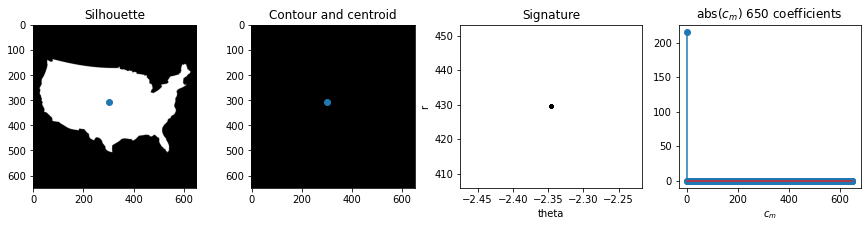

In [12]:
im = skimage.io.imread('contours/usa.png', as_gray=True)
# Get the white pixel coordinates to calculate the centroid of the white pixels
indices = np.where(im > 0.5)
pixel_coordinates = np.vstack([indices[1], indices[0]])
centroid = np.mean(pixel_coordinates, axis = 1)
# Get the white pixel coordinates and the centroid
image, contour, hierarchy = cv2.findContours(im.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour = np.vstack(contour).squeeze()
x = [c[0] for c in contour]
y = [c[1] for c in contour]
# Transform two-dimensional cartesian coordinate arrays x and y into polar coordinates
x_centered, y_centered = x-centroid[0], y-centroid[1]
rho = np.sqrt(x_centered**2+y_centered**2)
theta = np.arctan2(y_centered,x_centered)
# Apply the analysis equation to obtain M coefficients of the DTFS
N = len(rho)
c = (1/N)*np.fft.fft(rho)
c[N//2:] = 0+0j
c[0] = c[0]/2
# Show results
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = [15,3])
ax = axes[0]; ax.imshow(im, cmap = 'gray'); ax.set_title('Silhouette'); ax.scatter(centroid[0],centroid[1])
ax = axes[1]; ax.imshow(np.zeros(im.shape), cmap = 'gray'); ax.set_title('Contour and centroid')
ax.plot(x,y); ax.scatter(centroid[0],centroid[1])
ax = axes[2]; ax.plot(theta,rho,'k.'); ax.set_title('Signature'); ax.set_xlabel('theta'); ax.set_ylabel('r')
ax = axes[3]; ax.stem(abs(c)); ax.set_title('abs($c_m$) ' +str(len(c)) + ' coefficients'); ax.set_xlabel('$c_m$');

2) We apply the synthesis equation with the <i>M</i> first coefficients to reconstruct the DTFS

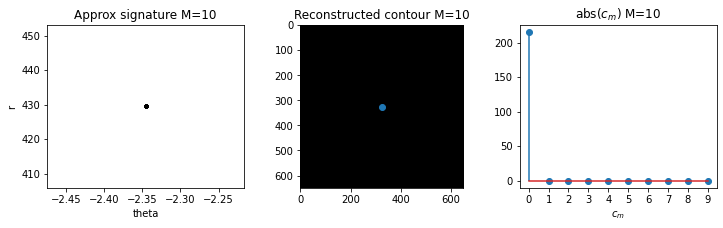

In [13]:
# Select the M first coefficients
M = 10
assert(M<=N)
c[M:] = 0+0j
# Apply the syntesis euation 
rho_r = 2*abs(N*np.fft.ifft(c))
# Convert back from polar to cartesian coordinates
centroid_im = np.array(im.shape)//2
x_r = rho_r * np.cos(theta)
y_r = rho_r * np.sin(theta)
x_r = x_r+centroid_im[0]
y_r = y_r+centroid_im[1]
# Show results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = [12,3])
ax = axes[0]; ax.plot(theta,rho_r,'k.'); ax.set_title('Approx signature M='+str(M))
ax.set_xlabel('theta'); ax.set_ylabel('r')
ax = axes[1]; ax.imshow(np.zeros(im.shape), cmap = 'gray'); ax.set_title('Reconstructed contour M='+str(M))
ax.plot(x_r,y_r); ax.scatter(centroid_im[0],centroid_im[1])
ax = axes[2]; ax.stem(abs(c[:M])); ax.set_title('abs($c_m$) M='+str(M)); ax.set_xlabel('$c_m$')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True));

3) We can scale the coefficients, and so the contour is also scaled

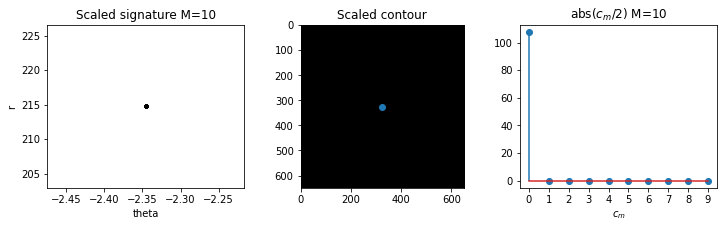

In [14]:
rho_scaled = 2*abs(N*np.fft.ifft(c/2))
x_scaled = rho_scaled * np.cos(theta)
y_scaled = rho_scaled * np.sin(theta)
x_scaled = x_scaled+centroid_im[0]
y_scaled = y_scaled+centroid_im[1]
# Show results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = [12,3])
ax = axes[0]; ax.plot(theta,rho_scaled,'k.'); ax.set_title('Scaled signature M='+str(M))
ax.set_xlabel('theta'), ax.set_ylabel('r')
ax = axes[1]; ax.imshow(np.zeros(im.shape), cmap = 'gray'); ax.set_title('Scaled contour')
ax.plot(x_scaled,y_scaled); ax.scatter(centroid_im[0],centroid_im[1])
ax = axes[2]; ax.stem(abs(c[:M]/2)); ax.set_title('abs($c_m$/2) M='+str(M)); ax.set_xlabel('$c_m$')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True));

4) We obtain the rotated contour in cartesian coordinates to test the time shift property

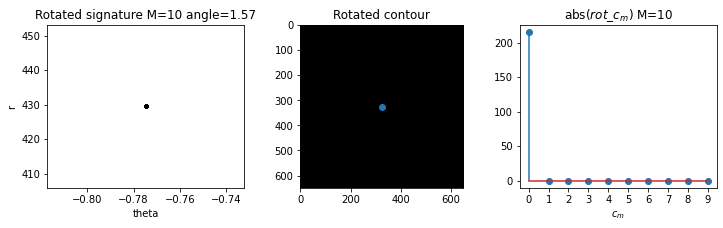

In [15]:
# Obtain the rotated contour in cartesian coordinates
rot_angle = np.pi/2
theta_rotated = (theta-rot_angle)%(2*np.pi)-np.pi
x_rotated = -rho_r * np.cos(theta_rotated)
y_rotated = -rho_r * np.sin(theta_rotated)
x_rotated = x_rotated+centroid_im[0]
y_rotated = y_rotated+centroid_im[1]

# Test the time-shift property
W0 = 2*np.pi/N
n0 = round(rot_angle/W0)
m = np.array(range(N))
rot_exp = np.exp(-1j*m*rot_angle)
rot_exp[M:] = 0+0j
c_rot = rot_exp*c
assert(np.all(abs(abs(c)-abs(c_rot)) < 0.0001))

# Show results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = [12,3])
ax = axes[0]; ax.plot(theta_rotated,rho_r,'k.')
ax.set_title('Rotated signature M='+str(M)+' angle='+str(round(rot_angle,2)))
ax.set_xlabel('theta'), ax.set_ylabel('r')
ax = axes[1]; ax.imshow(np.zeros(im.shape), cmap = 'gray'); ax.set_title('Rotated contour')
ax.plot(x_rotated,y_rotated); ax.scatter(centroid_im[0],centroid_im[1])
ax = axes[2]; ax.stem(abs(c_rot[:M])); ax.set_title('abs($rot$_$c_m$) M='+str(M)); ax.set_xlabel('$c_m$')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))